In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('0017.hk')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2010-03-24,52.915012,53.051567,52.095684,52.300514,29.860733,2551921.0,52.619144,52.368794,55.096356,-70.967858,-59.459566,0.136551,0.751049,52.014982,50.953271,1.061711,0.955883,6.821374,16.425878,52.300514
2010-03-25,51.959129,52.710182,51.344631,52.300514,29.860733,2536219.0,52.493969,52.328966,55.096356,-57.575865,-59.459566,-0.751053,-0.477943,52.058910,51.053067,1.005843,1.365551,6.821374,16.425878,53.392956
2010-03-26,52.095684,53.802620,52.027409,53.392956,30.484463,2510249.0,52.653283,52.425692,66.728957,-16.666641,-16.666641,0.955883,1.160717,52.264148,51.226392,1.037756,1.775211,35.279811,28.350674,53.666065
2010-03-29,53.461231,53.939175,53.461231,53.666065,30.640390,2631978.0,52.664662,52.590696,69.066249,-10.526300,-10.526300,0.068275,1.980045,52.479827,51.407108,1.072719,0.546219,40.712074,31.034403,53.188122
2010-03-30,53.256401,54.075729,52.915012,53.188122,30.367506,3142411.0,52.823976,52.698801,60.402809,-32.500024,-32.500024,0.955883,1.297268,52.588796,51.539035,1.049760,1.160717,19.626336,22.289705,51.890854


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_48527/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


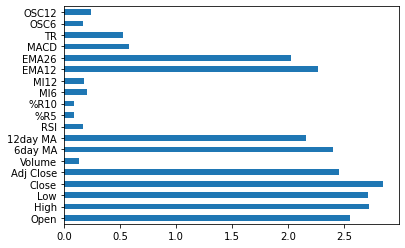

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2220, 1, 19) (2220, 1) (247, 1, 19) (247, 1)


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-10 18:51:46.262236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 18:51:46.262344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10,restore_best_weights = True)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
#     callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/300


2022-04-10 18:51:46.664470: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 18:51:47.958064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:51:48.168396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:51:48.204425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:51:48.311104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s - loss: 894.7705 

2022-04-10 18:51:48.369984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 3s 30ms/step - loss: 1349.5330 - val_loss: 3705.0544
Epoch 2/300
 1/32 [..............................] - ETA: 0s - loss: 1140.3639

2022-04-10 18:51:49.202375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:51:49.279469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:51:49.301549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step - loss: 924.4092 - val_loss: 3199.1528
Epoch 3/300
32/32 [==============================] - 0s 11ms/step - loss: 801.1021 - val_loss: 3038.7473
Epoch 4/300
32/32 [==============================] - 0s 11ms/step - loss: 559.1493 - val_loss: 2558.3345
Epoch 5/300
32/32 [==============================] - 0s 11ms/step - loss: 442.1989 - val_loss: 1958.6940
Epoch 6/300
32/32 [==============================] - 0s 11ms/step - loss: 308.9209 - val_loss: 1274.1750
Epoch 7/300
32/32 [==============================] - 0s 11ms/step - loss: 162.0990 - val_loss: 614.1705
Epoch 8/300
32/32 [==============================] - 0s 11ms/step - loss: 50.0314 - val_loss: 208.9434
Epoch 9/300
32/32 [==============================] - 0s 13ms/step - loss: 28.7363 - val_loss: 99.5987
Epoch 10/300
32/32 [==============================] - 0s 11ms/step - loss: 27.2868 - val_loss: 75.0877
Epoch 11/300
32/32 [==============================] - 0s 11ms/step - loss: 

32/32 [==============================] - 0s 11ms/step - loss: 7.8169 - val_loss: 9.8835
Epoch 83/300
32/32 [==============================] - 0s 11ms/step - loss: 7.7815 - val_loss: 9.8969
Epoch 84/300
32/32 [==============================] - 0s 11ms/step - loss: 7.7440 - val_loss: 9.9135
Epoch 85/300
32/32 [==============================] - 0s 11ms/step - loss: 7.7096 - val_loss: 9.9241
Epoch 86/300
32/32 [==============================] - 0s 10ms/step - loss: 7.6726 - val_loss: 9.9421
Epoch 87/300
32/32 [==============================] - 0s 11ms/step - loss: 7.6391 - val_loss: 9.9511
Epoch 88/300
32/32 [==============================] - 0s 11ms/step - loss: 7.6012 - val_loss: 9.9738
Epoch 89/300
32/32 [==============================] - 0s 11ms/step - loss: 7.5693 - val_loss: 9.9801
Epoch 90/300
32/32 [==============================] - 0s 11ms/step - loss: 7.5308 - val_loss: 10.0080
Epoch 91/300
32/32 [==============================] - 0s 11ms/step - loss: 7.5013 - val_loss: 10.0105
E

Epoch 162/300
32/32 [==============================] - 0s 10ms/step - loss: 5.2076 - val_loss: 11.7631
Epoch 163/300
32/32 [==============================] - 0s 10ms/step - loss: 5.1205 - val_loss: 11.1643
Epoch 164/300
32/32 [==============================] - 0s 11ms/step - loss: 5.1729 - val_loss: 11.9953
Epoch 165/300
32/32 [==============================] - 0s 10ms/step - loss: 5.2251 - val_loss: 11.4801
Epoch 166/300
32/32 [==============================] - 0s 10ms/step - loss: 5.4798 - val_loss: 12.6442
Epoch 167/300
32/32 [==============================] - 0s 10ms/step - loss: 5.8164 - val_loss: 12.3770
Epoch 168/300
32/32 [==============================] - 0s 10ms/step - loss: 6.5036 - val_loss: 14.1491
Epoch 169/300
32/32 [==============================] - 0s 10ms/step - loss: 7.4138 - val_loss: 14.4650
Epoch 170/300
32/32 [==============================] - 0s 10ms/step - loss: 8.7634 - val_loss: 16.9353
Epoch 171/300
32/32 [==============================] - 0s 10ms/step - los

32/32 [==============================] - 0s 10ms/step - loss: 6.3271 - val_loss: 13.1051
Epoch 242/300
32/32 [==============================] - 0s 12ms/step - loss: 3.9144 - val_loss: 8.5347
Epoch 243/300
32/32 [==============================] - 0s 10ms/step - loss: 3.7247 - val_loss: 11.8210
Epoch 244/300
32/32 [==============================] - 0s 10ms/step - loss: 3.2371 - val_loss: 8.4324
Epoch 245/300
32/32 [==============================] - 0s 10ms/step - loss: 3.6107 - val_loss: 13.0758
Epoch 246/300
32/32 [==============================] - 0s 10ms/step - loss: 3.6236 - val_loss: 8.8367
Epoch 247/300
32/32 [==============================] - 0s 10ms/step - loss: 4.4685 - val_loss: 14.3722
Epoch 248/300
32/32 [==============================] - 0s 10ms/step - loss: 4.7802 - val_loss: 10.5110
Epoch 249/300
32/32 [==============================] - 0s 9ms/step - loss: 6.9228 - val_loss: 18.5903
Epoch 250/300
32/32 [==============================] - 0s 10ms/step - loss: 7.6246 - val_lo

2022-04-10 18:53:27.681973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:53:27.746476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:53:27.769072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


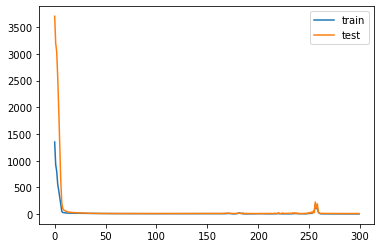

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

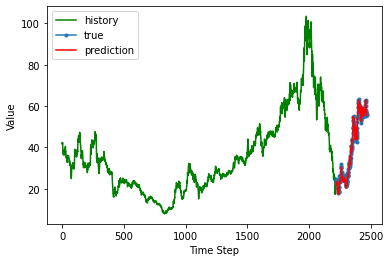

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

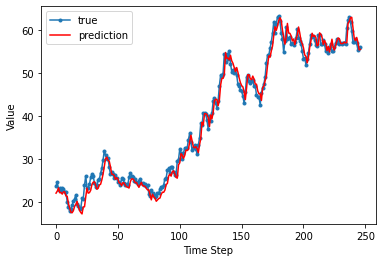

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.9867090582322439

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.03809108805275454

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

1.690275494869179

In [16]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_48527/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


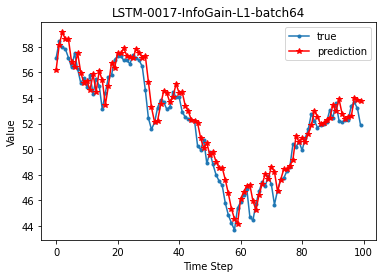

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('LSTM-0017-InfoGain-L1-batch64')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.9272730110358178

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.016188949026288427

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

1.0403797633163534